# Detailed introduction to `hqs-nmr-parameters`

This notebook gives an introduction to the `hqs-nmr-parameters` package, which is part of **HQS Spectrum Tools** and provides data structures, NMR parameter data, and functionality to process this data, including an option to directly extract a spin Hamiltonian in `struqture` format.

Please make sure that you are running this notebook in an environment with installed modules of **HQS Spectrum Tools** (`hqs-nmr`, `hqs-nmr-parameters`).

First, we have to import the chemistry module from the RDKit cheminformatics library.

In [1]:
# External module: RDKit
from rdkit import Chem

## Obtain a `struqture` spin Hamiltonian from the data base

Before going into the details of the data base, we will see one of its most important features: the construction of the spin Hamiltonian in `struqture` format. We will consider acrylonitrile as an example molecule. By accessing its data with the tag `"C2H3CN"` from the `molecules` dataset (this is explained in detail below), we can call the `nmr_hamiltonian` method on the molecule's parameters and a selected external magnetic field strength in Tesla. This provides us the spin hamiltonian in `struqture` format:

In [2]:
from hqs_nmr_parameters import nmr_hamiltonian
from hqs_nmr_parameters.examples import molecules

parameters = molecules["C2H3CN"]
hamiltonian = nmr_hamiltonian(parameters, field=11.7)

print("Type:", type(hamiltonian))
print(hamiltonian)

Type: <class 'struqture_py.spins.PauliHamiltonian'>
PauliHamiltonian{
0Z: -1.5650135101757584e9,
1Z: -1.565013791876559e9,
2Z: -1.5650130250243795e9,
0X1X: 1.413716694115407e0,
0Y1Y: 1.413716694115407e0,
0Z1Z: 1.413716694115407e0,
0X2X: 1.853539665617978e1,
0Y2Y: 1.853539665617978e1,
0Z2Z: 1.853539665617978e1,
1X2X: 2.8117254249628648e1,
1Y2Y: 2.8117254249628648e1,
1Z2Z: 2.8117254249628648e1,
}


Note that the NMR parameters can be passed to the `nmr_hamiltonian` function as `MolecularData` object (as it is done above) or as `NMRParameters` object. Both classes are explained in detail in the following. Furthermore, the `nmr_hamiltonian` function accepts additional optional arguments for specifying a reference isotope, reference shift, or the gyromagnetic ratios of the nuclei. These can be used to represent the Hamiltonian in a rotating frame of reference, though for details we refer to the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/spin_hamiltonian.html).

## Data structure

The `hqs-nmr-parameters` packages provides data structures that are meant for storing and accessing information on molecules and their NMR parameters, regardless whether they originate from an experimental measurement or a computational simulation. The most important classes for NMR spectra simulation are `MolecularData` and `NMRParameters`, which are explained in the following. Apart from the data structures themselves, the package also provides the molecular data for a variety of molecules, organized in datasets of type `MolecularDataSet`, which is described [below](#available-datasets).



### `MolecularData`

The central class is the Pydantic `MolecularData` class that stores all available information for a molecule. The following example molecule is part of a dataset that is explained later. Let's take a look at an acrylonitrile molecule (C<sub>2</sub>H<sub>3</sub>CN). Each data entry contains several information, including a name and a short description. For more detailed information, please refer to the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/molecular_data.html).

In [3]:
from hqs_nmr_parameters.examples import molecules

mol_data = molecules["C2H3CN"]

print("Type:", type(mol_data))
print("Name:", mol_data.name)
print("Chemical formula:", mol_data.formula)
print("Description:")
print(mol_data.description)

Type: <class 'hqs_nmr_parameters.code.data_classes.MolecularData'>
Name: Acrylonitrile
Chemical formula: C3H3N
Description:
1H parameters for acrylonitrile.
Values were obtained from Hans Reich's Collection, NMR Spectroscopy.
https://organicchemistrydata.org



The molecular structure is stored in a dictionary with up to three possible objects of type `ChemicalStructure`. It may contain the structure in three-dimensional XYZ format, as a two-dimensional Molfile or a simple SMILES string.

dict_keys(['Molfile'])
Type: <class 'hqs_nmr_parameters.code.data_classes.ChemicalStructure'>
Total electric charge: 0
Ordered list of atomic symbols: ['C', 'C', 'C', 'H', 'H', 'H', 'N']


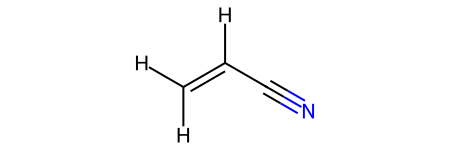

In [4]:
# Our example only has a Molfile entry
print(mol_data.structures.keys())

# ChemicalStructure class
print("Type:", type(mol_data.structures["Molfile"]))
print("Total electric charge:", mol_data.structures["Molfile"].charge)
print("Ordered list of atomic symbols:", mol_data.structures["Molfile"].symbols)

# The RDKit cheminformatics package can be used to construct and visualize the molecule
structure_block = mol_data.structures["Molfile"].content
Chem.MolFromMolBlock(structure_block, removeHs=False)

Now let us take a look at the contents that are relevant for simulating an NMR spectrum: chemical shifts and *J*-coupling constants. They are provided as lists of tuples consisting of the atomic reference (atom or atom pair) and the corresponding value. Analogously, the object contains a list of isotope definitions for each atom. Note that neither of these lists needs to be complete as an entry exists only if data is available. However, a chemical shift value can only be present if the isotope for the corresponding atom is defined and a *J*-coupling constant can only be present if chemical shift values are available for both atoms involved in the coupling.

In [5]:
# In our example, data is available for all three hydrogen atoms in the molecule
print("List of isotopes:", mol_data.isotopes)
print("List of chemical shift values:", mol_data.shifts)
print("List of J-coupling constants:", mol_data.j_couplings)

List of isotopes: [(3, Isotope(mass_number=1, symbol='H')), (4, Isotope(mass_number=1, symbol='H')), (5, Isotope(mass_number=1, symbol='H'))]
List of chemical shift values: [(3, 5.79), (4, 5.97), (5, 5.48)]
List of J-coupling constants: [((3, 4), 0.9), ((3, 5), 11.8), ((4, 5), 17.9)]


In addition to storing data, the `MolecularData` class implements some useful functionality. For instance, specific nuclei can be excluded using the `keep_nuclei` and `drop_nuclei` functions. The functions work either with specific atom indices or by specifying selected isotopes.

In [6]:
mol_data_only_3_4 = mol_data.keep_nuclei(atoms=[3, 4])
mol_data_empty = mol_data.drop_nuclei(isotopes=["1H"])

print("Only shifts for atoms 3 and 4:", mol_data_only_3_4.shifts)
print("Not shifts left:", mol_data_empty.shifts)

Only shifts for atoms 3 and 4: [(3, 5.79), (4, 5.97)]
Not shifts left: []


Lastly, it is worth mentioning that an instance of `MolecularData` can be serialized and saved to a JSON file with the `write_file` class method. Analogously, an object can be read via `read_file`. For more detailed information, please refer to the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/molecular_data.html#serialization-saving-in-a-json-file-of-a-moleculardata-object-and-deserialization).

Besides reading a `MolecularData` instance from a JSON file, it is also possible to create it from reading a YAML file in a specific format. This is the easiest way to read your own data and convert it into the format used inside the HQS software. A detailed description on how this can be achieved is given in a separate section in the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/text_input.html) and an example is shown in [tutorial 1](1_getting_started.ipynb).

### `NMRParameters`

The `NMRParameters` class contains only the relevant parameters of a molecular system needed for a simulation of an NMR spectrum, i.e., only the isotope information, chemical shifts, and *J*-coupling constants. It can be obtained from a `MolecularData` object via the `spin_system` function and contains ordered lists with the values. Note that the atom indices used in the `MolecularData` object are omitted. The isotopes and chemical shifts in `NMRParameters` are stored in consistent lists of the same length and their element indices are used to specify the coupling spins in the `j_couplings` attribute.

In [7]:
parameters = mol_data.spin_system()

print("Type:", type(parameters))
print("Isotopes:", parameters.isotopes)
print("Chemical shift values:", parameters.shifts)
print("J-coupling constants:", parameters.j_couplings)

Type: <class 'hqs_nmr_parameters.code.data_classes.NMRParameters'>
Isotopes: [Isotope(mass_number=1, symbol='H'), Isotope(mass_number=1, symbol='H'), Isotope(mass_number=1, symbol='H')]
Chemical shift values: [5.79, 5.97, 5.48]
J-coupling constants: [((0, 1), 0.9), ((0, 2), 11.8), ((1, 2), 17.9)]


## Available datasets

The `hqs-nmr-parameters` package contains a range of different datasets. Each dataset is an instance of the `MolecularDataSet` class that stores multiple `MolecularData` entries with unique molecular identifiers. Each dataset also contains a description with useful information on the origin of the included data. As an example, we can inspect the example molecule dataset that was already used above:

In [8]:
from hqs_nmr_parameters.examples import molecules as example_molecules

print("Type:", type(example_molecules))
print("Number of entries:", len(example_molecules))
print("All molecular identifiers:", example_molecules.keys)
print("Description:")
print(example_molecules.description)

Type: <class 'hqs_nmr_parameters.code.data_classes.MolecularDataSet'>
Number of entries: 30
All molecular identifiers: ['limonene_DFT', 'endo-dicyclopentadiene_DFT', 'Artemisinin_exp', 'cis-3-chloroacrylic_acid_exp', 'C10H7Br', 'cyclopentadiene_DFT', 'C3H8', '1,2,4-trichlorobenzene', 'CH3Cl', 'CH3Cl_13C', 'C10H8', 'Androstenedione', 'C6H6', 'CHCl3', 'C2H3CN', 'C2H5Cl', '1,2-di-tert-butyl-diphosphane', 'C6H5NO2', 'CHCl3_13C', 'C2H5OH', 'Cinnamaldehyde', 'C2H6', 'Triphenylphosphine_oxide', 'exo-dicyclopentadiene_DFT', 'camphor_exp', 'C2H3NC', 'Artemisinin', 'camphor_DFT', 'Anethole', 'H2CCF2']
Description:
The data set contains a selection of example NMR parameters for various molecules, with parameters
coming from different sources: either from experimental results or from computations. For more
details on each molecule, please inspect the respective description field.



The `examples.molecules` dataset contains a rather diverse set of small molecules from different origins that can be used easily and quickly for testing. A larger set of molecules with consistent data is included in the `cheshire` dataset that uses molecules from the [CHESHIRE](http://cheshirenmr.info/) data base and comprises a set of around 100 molecules with experimental chemical shift data available and calculated data provided for ~60 molecules using the same approach for all simulations. Different variants of this dataset are available:

- `calculated`: Contains mainly <sup>1</sup>H NMR chemical shifts and *J*-coupling constants purely calculated using density functional theory (DFT).
- `combined`: Contains experimental <sup>1</sup>H NMR chemical shifts combined with *J*-coupling constants calculated with DFT.
- `experimental_shifts_only`: Contains only experimental <sup>1</sup>H NMR chemical shifts and no *J*-coupling data.
- `calculated_full`/`combined_full`: Same as `calculated`/`combined`, but also contains data for <sup>13</sup>C NMR chemical shifts.
- `molecules`: Alias for `combined`.

Two of these variants are exemplified below. For more information, please refer to the individual descriptions and the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/datasets.html#cheshire-module).

In [9]:
from hqs_nmr_parameters.cheshire import calculated as cheshire_calculated
from hqs_nmr_parameters.cheshire import combined as cheshire_combined

print("Number of molecules in calculated dataset:", len(cheshire_calculated))
print("Number of molecules in combined dataset:", len(cheshire_combined))
print("Description of combined dataset:")
print(cheshire_combined.description)

Number of molecules in calculated dataset: 65
Number of molecules in combined dataset: 60
Description of combined dataset:
Experimental shifts and theoretical J-couplings for the rigid molecules of the Cheshire set, except for ['Cyclopropanone', 'Bicyclobutane', 'Cyclopentanone', 'Fluorobenzene', 'Indole'] due to incompatible data.
Shifts and couplings only for nuclei ['1H', '19F', '31P', '29Si'].


Another important and even larger set of molecules is the [GISSMO](https://gissmo.bmrb.io/) database that comprises more than 1000 organic molecules. It contains only experimentally determined proton NMR parameters, more precisely <sup>1</sup>H NMR shifts and <sup>1</sup>H&ndash;<sup>1</sup>H J-couplings for all compounds, as well as additional <sup>1</sup>H&ndash;<sup>19</sup>F or <sup>1</sup>H&ndash;<sup>31</sup>P J-coupling data for some of the molecules. As there is no shift data for any other isotopes than <sup>1</sup>H, it is possible to import the following slightly different datasets:

- `experimental_dummy_hetero_shifts`: Contains all available experimental shift and J-coupling data. The chemical shift values of <sup>19</sup>F and <sup>31</sup>P are set to dummy values of 0.0 ppm.
- `experimental_no_hetero_nuclei`: Contains only the available <sup>1</sup>H NMR shifts and <sup>1</sup>H&ndash;<sup>1</sup>H J-coupling constants.
- `molecules`: Alias for `experimental_dummy_hetero_shifts`.

In the field below, the dataset is presented along with an example molecule. For more information, please refer to the other individual descriptions and the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/datasets.html#gissmo-module).

In [10]:
from hqs_nmr_parameters.gissmo import molecules as gissmo_molecules

print("Number of molecules in the dataset:", len(gissmo_molecules))
print("Description:")
print(gissmo_molecules.description)

# Show an example molecule: p-fluorobenzoic acid
example_gissmo = gissmo_molecules["bmse000739"]
print("Isotopes:", example_gissmo.isotopes)
print("Shifts:", example_gissmo.shifts)
print("J-couplings:", example_gissmo.j_couplings)
print("Description:")
print(example_gissmo.description)

Number of molecules in the dataset: 1226
Description:
Experimental 1H-NMR shifts and J-couplings of the GISSMO data set.
For more information, see: https://gissmo.bmrb.io/library
For the BMRB entries (keys bmseXXXXXX), experimental NMR spectra are available under: https://bmrb.io/metabolomics/
This set contains experimental J-coupling constants from 1H to 1H, 19F, and 31P.
The NMR shifts of the hetero nuclei (19F/31P) are set to dummy values of 0.0 ppm.

Isotopes: [(7, Isotope(mass_number=19, symbol='F')), (10, Isotope(mass_number=1, symbol='H')), (11, Isotope(mass_number=1, symbol='H')), (12, Isotope(mass_number=1, symbol='H')), (13, Isotope(mass_number=1, symbol='H'))]
Shifts: [(7, 0.0), (10, 7.16217), (11, 7.16217), (12, 7.88069), (13, 7.88069)]
J-couplings: [((7, 10), 8.916), ((7, 11), 8.916), ((7, 12), 5.584), ((7, 13), 5.584), ((10, 11), 2.739691), ((10, 12), 8.771672), ((11, 13), 8.771672), ((12, 13), 3.241358)]
Description:
NMR parameters for molecule 'P-fluorobenzoic-acid' fro

Additionally, there are some smaller datasets with special data in the `phytolab` and `assignments` modules. Please see the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/datasets.html) for further information.

A combination of all available data in the `hqs-nmr-parameters` package is available in the `merged` module. It is available as `calculated`, `combined`, and `molecules` dataset and can also be imported from the top level. Note that the molecule identifiers in this dataset have a prefix with the name of the dataset they originate from.

In [11]:
from hqs_nmr_parameters.merged import molecules as molecules_merged
from hqs_nmr_parameters import molecules

key_example = "examples/C10H7Br"
key_cheshire = "cheshire_combined/42"
print(f"Two examples of molecular identifiers: {key_example}, {key_cheshire}")

print(molecules_merged == molecules)
print(molecules[key_example] == example_molecules[key_example.replace("examples/", "")])
print(molecules[key_cheshire] == cheshire_combined[key_cheshire.replace("cheshire_combined/", "")])

Two examples of molecular identifiers: examples/C10H7Br, cheshire_combined/42
True
True
True


The last dataset that is worth mentioning here is the `free_trial` set that contains all the data that is available in the free trial version of HQSpectrum. It can be imported from the top level as well.

In [12]:
from hqs_nmr_parameters import free_trial

print("Number of entries:", len(free_trial))
print(f"Two examples of molecular identifiers: {free_trial.keys[0]}, {free_trial.keys[46]}")
print("Description:")
print(free_trial.description)

Number of entries: 83
Two examples of molecular identifiers: examples/limonene_DFT, cheshire/42
Description:
Combination of data for the free trial of HQSpectrum. The set combines a selection of molecules
from the 'examples' module with DFT data for a subset of the CHESHIRE benchmark set.



## Final remarks

You now know how to use the data provided in the `hqs-nmr-parameters` packages and can use it to simulate NMR spectra. For an introduction on how to simulate NMR spectra with **HQS Spectrum Tools**, we recommend taking a look at the other example notebooks, especially [tutorial 1](1_getting_started.ipynb) [and 3](3_customization.ipynb) for an introduction to the HQS NMR solver.

For further information on the data and data structure of `hqs-nmr-parameters` itself, see the [database](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database.html) section of the documentation.